In [1]:
#the aim of this model is to predict median housing prices given a dataset.

In [2]:
from sklearn.linear_model import LinearRegression
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

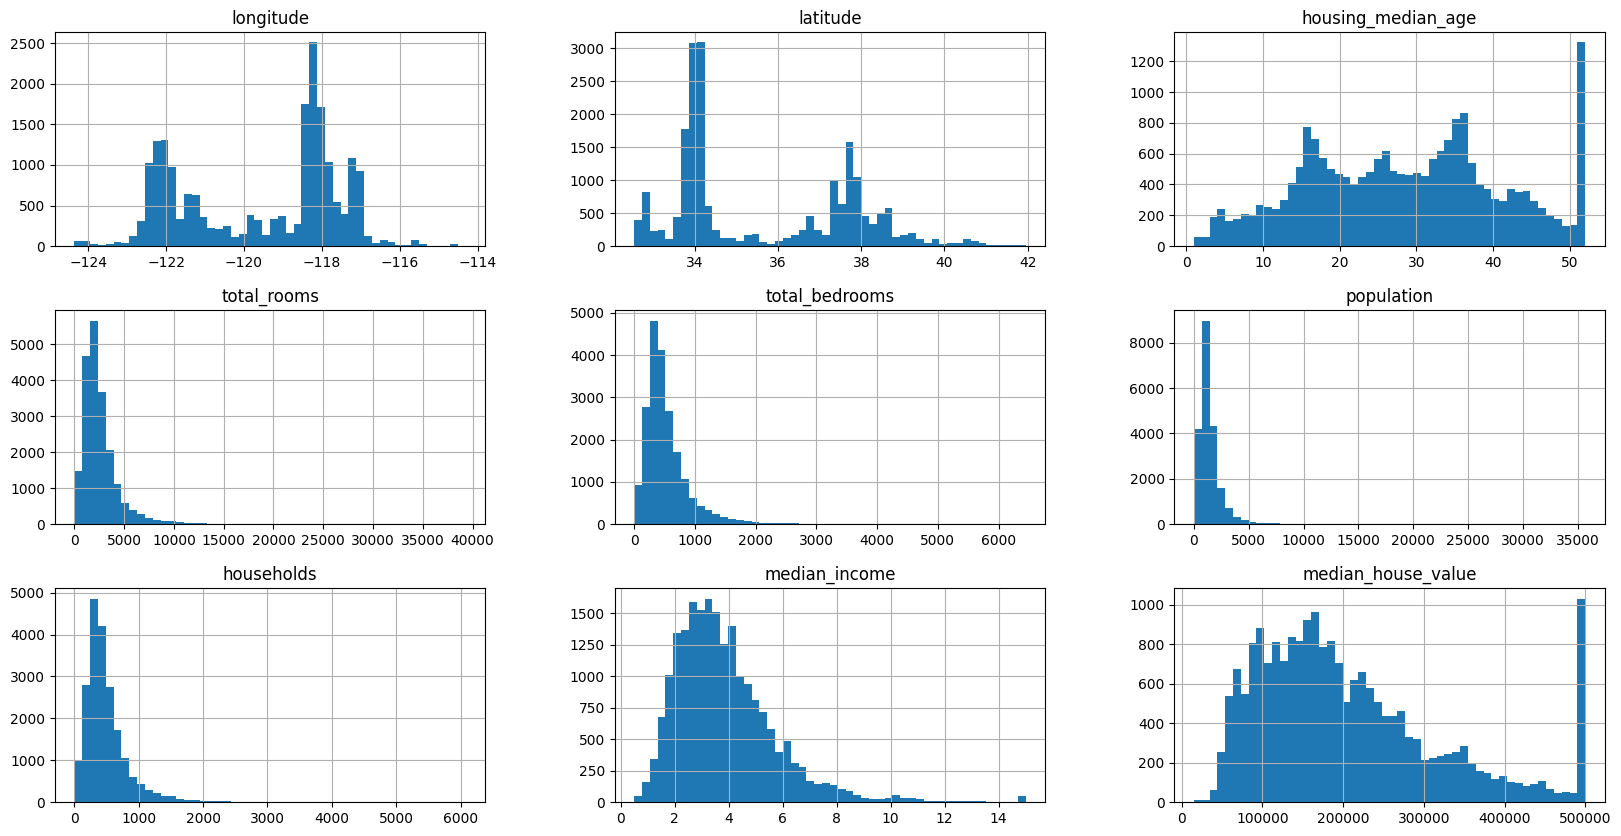

In [3]:
housing = pd.read_csv('datasets/housing/housing.csv')
housing.hist(bins = 50, figsize=(20,10))
plt.show()

/var/folders/0k/sbk6ndw15xbdgrg8xryhmd100000gn/T/ipykernel_39009/2185455976.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_by_category = housing.groupby('income_category')['median_income'].median()


income_category
1    1.26295
2    2.34820
3    3.66070
4    5.09230
5    7.03275
Name: median_income, dtype: float64

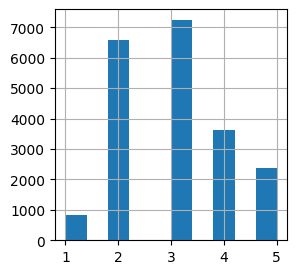

In [4]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)
# ensuring that the model has adequate data from 
# each group to understand how their unique characteristics influence house prices.
housing['income_category'] = pd.cut(housing['median_income'], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])
housing['income_category'].hist(figsize = (3, 3))

median_by_category = housing.groupby('income_category')['median_income'].median()
median_by_category

In [5]:
# Ensuring that the relative distribution of income categories in the training and testing sets 
# is the same as in the original dataset. This prevents bias that could occur with a random split, 
# where certain income categories might be underrepresented or overrepresented.
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_idx, test_idx in split.split(housing, housing['income_category']):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]
strat_test_set['income_category'].value_counts() / len(strat_test_set)

for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_category', axis = 1, inplace = True)

<Axes: xlabel='longitude', ylabel='latitude'>

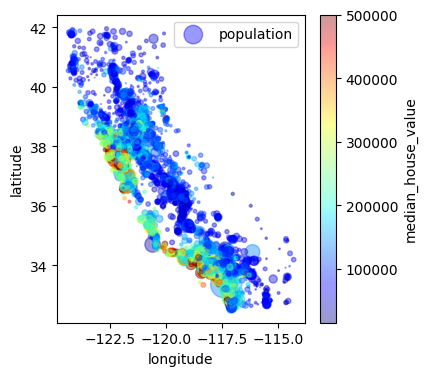

In [6]:
housing = strat_train_set.copy()
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', figsize = (4, 4), alpha = 0.4,
            s = housing['population']/100, label = 'population', c = 'median_house_value', 
            cmap = plt.get_cmap('jet'), colorbar = True)

In [7]:
numeric_housing = housing.select_dtypes(exclude='object')
corr_matrix = numeric_housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False) #income closely related to house val

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [8]:
#derive new features
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [9]:
numeric_housing = housing.select_dtypes(exclude='object')
corr_matrix = numeric_housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

In [10]:
housing = strat_train_set.drop('median_house_value', axis = 1) #features
housing_labels = strat_train_set['median_house_value'].copy() #labels

In [11]:
imputer = SimpleImputer(strategy = 'median')
housing_num = housing.drop('ocean_proximity', axis = 1) #exclude text dtype as imputation is only on int
imputer.fit(housing_num) #calculate median vals
imputer.statistics_
housing_num.median().values #compare imputer median with manual medians

X = imputer.transform(housing_num) #apply imputation on dataset
housing_tr = pd.DataFrame(X, columns = housing_num.columns)

In [12]:
#handle text labels
housing_cat = housing['ocean_proximity'].values.reshape(-1, 1)

In [13]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:5]
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [14]:
#no inherent ordering of labels, and variables are independent so use one hot
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
#sparse matrix saves only non-zero values to save memory for large datasets. but can convert to dense:
housing_cat_1hot.toarray()
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [15]:
# instead of deriving new features manually, we can create custom transformer classes
# and leverage the pipeline feature of Sklearn to help with these sequences by applying it to the dataset

In [16]:
# base class for all estimators in scikit-learn. An estimator is any object that can estimate some parameter
# creating transformers that can transform data. A transformer is any object that modifies the input data, such as feature scaling, encoding categorical variables, or creating new features.
from sklearn.base import BaseEstimator, TransformerMixin

rooms_index, bedrooms_index, population_index, households_index = 3, 4, 5, 6 #indexes for our imputed df (X)

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self 
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_index] / X[:, households_index]
        population_per_household = X[:, population_index] / X[:, households_index]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_index] / X[:, rooms_index]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
# contains all the original features from housing dataset plus any additional features added by the transformer.
housing_extra_attribs = attr_adder.transform(housing.values) 
housing_extra_attribs[:5]

array([[-121.46, 38.52, 29.0, 3873.0, 797.0, 2237.0, 706.0, 2.1736,
        'INLAND', 5.485835694050992, 3.168555240793201],
       [-117.23, 33.09, 7.0, 5320.0, 855.0, 2015.0, 768.0, 6.3373,
        'NEAR OCEAN', 6.927083333333333, 2.6236979166666665],
       [-119.04, 35.37, 44.0, 1618.0, 310.0, 667.0, 300.0, 2.875,
        'INLAND', 5.3933333333333335, 2.223333333333333],
       [-117.13, 32.75, 24.0, 1877.0, 519.0, 898.0, 483.0, 2.2264,
        'NEAR OCEAN', 3.886128364389234, 1.8592132505175984],
       [-118.7, 34.28, 27.0, 3536.0, 646.0, 1837.0, 580.0, 4.4964,
        '<1H OCEAN', 6.096551724137931, 3.1672413793103447]], dtype=object)

In [17]:
#apply the transformation class to dataset, along with other methods (scaling, etc.)
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('attribs_adder', CombinedAttributesAdder()), #add features from housing_extra_attribs
    ('std_scaler', StandardScaler())
])

housing_num_tr = numerical_pipeline.fit_transform(housing_num)
housing_num_tr[:2]

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.01739526,  0.00622264,
        -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.56925554, -0.04081077,
        -0.81086696]])

In [19]:
#use the numerical pipeline (which handles only numerical columns)
#to create a new pipeline which also handles in text columns
#to have one standardized pipeline

from sklearn.compose import ColumnTransformer #for both text + numerical

numerical_attribs = list(housing_num)
categorical_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, numerical_attribs), 
    ('cat', OneHotEncoder(), categorical_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing) #final feature vector for modelling
# feature_names = full_pipeline.get_feature_names_out() #get feature names corresponding to values in feature vector
# feature_names

Model Training

In [20]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) #housing labels is median house value from earlier..

#test on few instances on train set 
data_batch = housing.iloc[:5]
data_labels = housing_labels.iloc[:5]
data_prepped = full_pipeline.transform(data_batch)
print("Predictions:", lin_reg.predict(data_prepped))
print("Labels:", list(data_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [21]:
from sklearn.metrics import mean_squared_error #cost function to test on whole dataset
housing_predictions = lin_reg.predict(housing_prepared)
linear_mse = mean_squared_error(housing_labels, housing_predictions)
linear_rmse = np.sqrt(linear_mse)
linear_rmse

68627.87390018745

median housing values are ranging between 120000 to 265000... off by 69,050... Underfitting.

In [22]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse #overfitting 

0.0

In [23]:
#use cross validation instead 
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)
tree_rmse_scores = np.sqrt(-scores)

print(tree_rmse_scores)
print(tree_rmse_scores.mean()) #mean
print(tree_rmse_scores.std()) #standard dev

[73851.68953147 71477.55957841 68085.92388072 72157.98265091
 71357.47922418 77948.3383804  71699.37128008 73341.25268667
 68066.73065786 71357.65197915]
71934.39798498483
2693.91406296487


In [24]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse #off by ~18,000.. best model so far.

18677.219054150435

hyperparam tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                            scoring='neg_mean_squared_error',
                           return_train_score = True)
#Train the model using each combination of the specified hyperparameters in the param_grid
#Evaluate the performance of each combination using cross-validation and the specified scoring metric.
grid_search.fit(housing_prepared, housing_labels)

In [ ]:
#best model found using 6 features and 30 decision trees
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)
    break
    # yield

In [ ]:
#can drop less useful features using this..
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_hhold']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = numerical_attribs + extra_attribs + cat_one_hot_attribs 
sorted(zip(feature_importances, attributes), reverse = True)

In [ ]:
#test on test dataset
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

In [ ]:
#test precision using confidence interval
from scipy import stats 
confidence = 0.95 
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc = squared_errors.mean(), 
                        scale = stats.sem(squared_errors)))


In [ ]:
lin_reg.coef_